The most popular deep learning architectures for image processing and recognition are Convolutional neural networks (CNNs). Nevertheless, CNN's have recently become common in solving NLP-related issues. This technique treats each comment as an image by displaying the text in vector form and applying a CNN. 

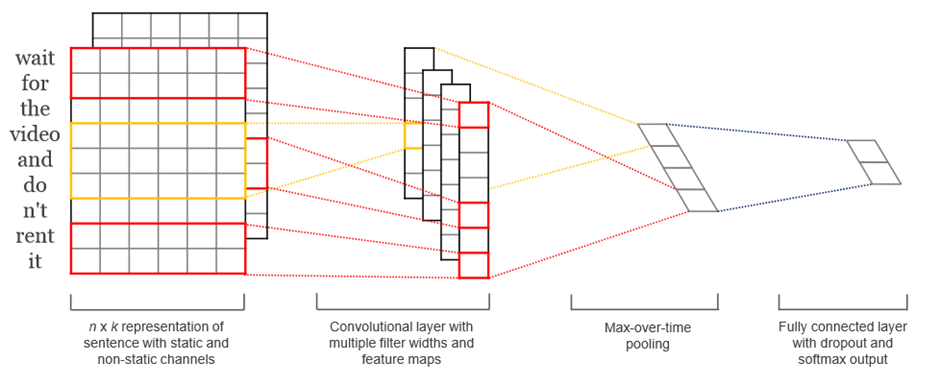

Referances

1. https://dennybritz.com/posts/wildml/implementing-a-cnn-for-text-classification-in-tensorflow/

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
print("TF Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12354885265407430509
 xla_global_id: -1]

In [ ]:
dir_path = "/content/gdrive/MyDrive/Colab Notebooks/Final_Project_Yashkumar_1138765/"

In [ ]:
# Loading dataset
data1=pd.read_excel(dir_path + "Data/Eng_Dataset.xlsx")
data2=pd.read_excel(dir_path + "Data/Guj_Dataset.xlsx")
data3=pd.read_excel(dir_path + "Data/Hin_Dataset.xlsx")
data4=pd.read_excel(dir_path + "Data/Mar_Dataset.xlsx")
data5=pd.read_excel(dir_path + "Data/Pun_Dataset.xlsx")

In [ ]:
# Concatanating the files data
train = pd.concat([
    data1[['comment_text', 'toxic']],
    data2[['comment_text', 'toxic']],
    data3[['comment_text', 'toxic']],
    data4[['comment_text', 'toxic']],
    data5[['comment_text', 'toxic']]
])

In [ ]:
train.head()

,comment_text,toxic
0,Explanation Why the edits made under my userna...,0.0
1,D aww He matches this background colour I m se...,0.0
2,Hey man I m really not trying to edit war It s...,0.0
3,More I can t make any real suggestions on imp...,0.0
4,You sir are my hero Any chance you remember wh...,0.0


In [ ]:
train.tail()

,comment_text,toxic
2994,ਇਸ ਨੂੰ ਇਸ ਦੇ ਕਾਲੇ ਰਿੰਗ ਵਿੱਚ ਹਾਰਡ Fuck OOOOOOOO...,1.0
2995,"ਪ੍ਰਸ਼ਾਸਕ ਕੁਲੀਨਵਾਦੀ ਹਨ, ਮੈਨੂੰ ਕੋਈ ਪਰਵਾਹ ਨਹੀਂ ਹ...",1.0
2996,ਇਸ ਵੇਸਲੇ ਆਊਟਰਿਗਰ ਨੂੰ ਫੱਕ ਕਰੋ ਅਤੇ ਬਾਅਦ ਵਿੱਚ ਜੌਨ...,1.0
2997,ਬ੍ਰਾਂਡਨ ਗੇਅ ਹੈ ਉਹ ਆਪਣੇ ਗਧੇ ਅਤੇ ਮੂੰਹ ਨੂੰ ਡੇਲਡੋਸ...,1.0
2998,"RE ਅਤੇ ਉਸਨੇ ਆਪਣਾ ਨੱਕ ਵੀ ਚੁੱਕਿਆ, ਤੁਸੀਂ ਕਿਸ ਤਰ੍ਹ...",1.0


In [ ]:
train.shape

(14995, 2)

In [ ]:
# Calculate Maximum comment size
train['comment_text'].apply(lambda x:len(str(x).split())).max()

2614

In [ ]:
# Changing column datatypes
train = train.astype({"toxic": int, "comment_text": str})

In [ ]:
train.dtypes

comment_text    object
toxic            int64
dtype: object

In [ ]:
# Shuffle dataset
train = train.sample(frac=1).reset_index(drop=True)

In [ ]:
# split the data in train and test set
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
# Declaring Tokenizer
token = text.Tokenizer(num_words=None, lower=False)
max_len = 1500

In [ ]:
# tokenizing data

token.fit_on_texts(list(xtrain) + list(xvalid))

# Converting texts to sequnces
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

In [ ]:
xtrain_seq[0]

[31,
 185,
 81,
 214,
 14,
 76,
 789,
 3,
 21,
 31,
 11416,
 27,
 2195,
 3737,
 462,
 458,
 20862,
 271,
 11417,
 25,
 545,
 110,
 105,
 1620,
 27,
 185,
 759,
 177]

In [ ]:
# Padding the sequences
xtrain_pad = tf.keras.utils.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = tf.keras.utils.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
xtrain_pad[0]

array([  0,   0,   0, ..., 185, 759, 177], dtype=int32)

In [ ]:
xtrain_pad[0].shape

(1500,)

In [ ]:
# Sequential Neural Network
model=Sequential()
model.add(Embedding(len(word_index) + 1, 
                    300, 
                    input_length=max_len))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         24357900  
                                                                 
 conv1d (Conv1D)             (None, 1500, 64)          57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 12000)             0

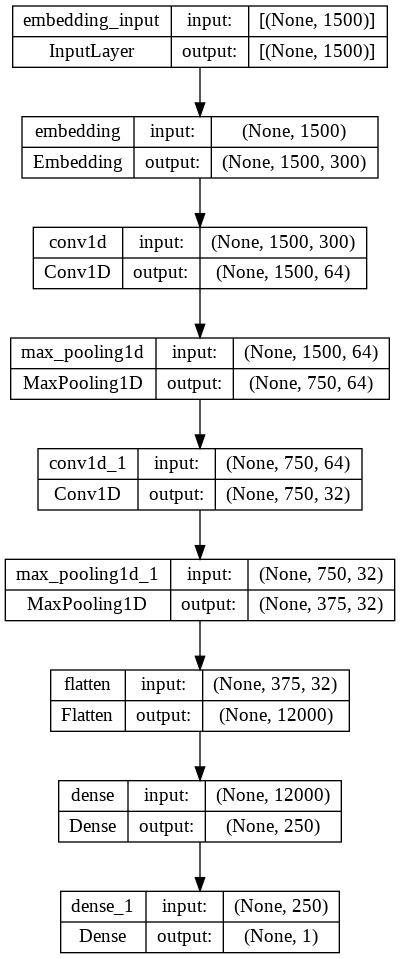

In [ ]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [ ]:
# Callback EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
# Fit the model
history=model.fit(xtrain_pad, ytrain,validation_split=0.2, epochs=5, batch_size=128, callbacks=[es])

Epoch 1/5
85/85 [==============================] - 211s 2s/step - loss: 0.6015 - accuracy: 0.6431 - val_loss: 0.4442 - val_accuracy: 0.7940
Epoch 2/5
85/85 [==============================] - 211s 2s/step - loss: 0.2046 - accuracy: 0.9190 - val_loss: 0.3352 - val_accuracy: 0.8555
Epoch 3/5
85/85 [==============================] - 209s 2s/step - loss: 0.0255 - accuracy: 0.9927 - val_loss: 0.4355 - val_accuracy: 0.8629
Epoch 4/5
85/85 [==============================] - 209s 2s/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.5196 - val_accuracy: 0.8614
Epoch 5/5
85/85 [==============================] - 212s 3s/step - loss: 4.1384e-04 - accuracy: 1.0000 - val_loss: 0.5668 - val_accuracy: 0.8607
Epoch 5: early stopping


In [ ]:
# Taking values from history callback object
train_values = history.history['loss']
val_values = history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epoch=5

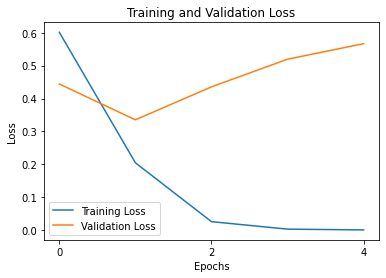

In [ ]:
from matplotlib.pylab import plt
from numpy import arange
 
# integers sequence to represent the epoch numbers
epochs = range(0, epoch)
 
# Plot and label loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# tick locations
plt.xticks(arange(0, epoch, 2))
 
# Display plot
plt.legend(loc='best')
plt.show()

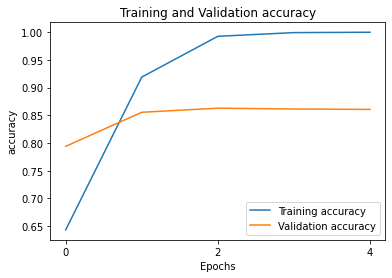

In [ ]:
# integers sequence to represent the epoch numbers
epochs = range(0, epoch)
 
# Plot and label loss values
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
 
# Add title and axes labels
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
 
# tick locations
plt.xticks(arange(0, epoch, 2))
 
# Display plot
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making predications on validation data
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict(xvalid_pad, verbose=0).ravel()]

# Calculating Accuracy Score and Classification report
print("Accuracy: %.2f%%" % (accuracy_score(yvalid, predictions)*100))
print(classification_report(yvalid, predictions))

# Confusion matrix
cf_matrix =confusion_matrix(yvalid, predictions)
pd.DataFrame(cf_matrix)

Accuracy: 87.33%
              precision    recall  f1-score   support

           0       0.91      0.82      0.87       750
           1       0.84      0.92      0.88       750

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



,0,1
0,618,132
1,58,692


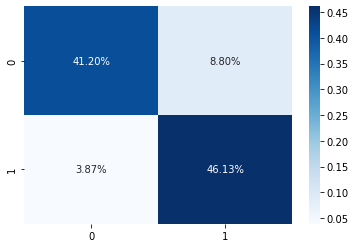

In [ ]:
# Plot Confusion matrix
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
path = dir_path + '/model/my_CNN_model.h5'

In [ ]:
# save model in h5 file
model.save(path, save_format='h5', overwrite=True)

In [ ]:
# load model
l_model = tf.keras.models.load_model(path)
l_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         24357900  
                                                                 
 conv1d (Conv1D)             (None, 1500, 64)          57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 32)           6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 12000)             0

In [ ]:
# Evaluate model on actual data
def evaluate(text):
  token.fit_on_texts(text)
  tokens = token.texts_to_sequences(text)
  seq = []
  for i in tokens:
    for j in i:
      seq.append(j)
  seq = np.array(seq)

  text_pad = tf.keras.utils.pad_sequences([seq,], maxlen=max_len)
  word_index = token.word_index

  result = l_model.predict(text_pad, verbose=0) 
  print("%.5f" % result[0])

  if(result >=0.5):
    print("Toxic")
  else:
    print("Non-Toxic")

In [ ]:
text= " डी aww वह इस पृष्ठभूमि रंग से मेल खाता है मैं प्रतीत होता है कि धन्यवाद टॉक 21 51 जनवरी 11 2016 यूटीसी के साथ फंस गया है"

evaluate(text)

0.01654
Non-Toxic
